In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from unified_model.unified import UnifiedModel

In [3]:
# Let's define our model that we need to simulate
from scipy.signal import savgol_filter
from unified_model.unified import UnifiedModel
from unified_model import mechanical_components
from unified_model import electrical_components
from unified_model import CouplingModel
from unified_model import metrics
from unified_model import evaluate
from unified_model.utils.utils import collect_samples
from flux_modeller.model import CurveModel
from unified_model.evaluate import Measurement
from unified_model import parameter_search

import nevergrad as ng
import pandas as pd
import cloudpickle
import numpy as np
import copy
from plotnine import *

from typing import Tuple, Union, Any, Dict, List
import warnings
warnings.simplefilter('ignore')

with open('../scripts/ABC.config', 'rb') as f:
    ABC_CONFIG = cloudpickle.load(f)

## Helper functions
`A`, `B`, `C` are my original "groundtruth" devices.  
`D` is the pseudo-optimal device with one coil and two magnets. We treat it as an additional "groundtruth" device.

### Create prototype model components

In [4]:
def _create_model_D_components():
    coil_config = electrical_components.CoilConfiguration(
        c=1,
        n_z=88,
        n_w=20,
        l_ccd_mm=0,
        ohm_per_mm=1079 / 1000 / 1000,
        tube_wall_thickness_mm=2,
        coil_wire_radius_mm=0.143/2,
        coil_center_mm=78,
        inner_tube_radius_mm=5.5
    )
    
    magnet_assembly = mechanical_components.MagnetAssembly(
        m=2,
        l_m_mm=10,
        l_mcd_mm=24,
        dia_magnet_mm=10,
        dia_spacer_mm=10
    )
    
    curve_model = CurveModel.load('../data/flux_curve_model/flux_curve_model_2021_05_11.model')
    z, phi = curve_model.predict_curves(np.array([[coil_config.n_z, coil_config.n_w]]))
    phi = phi.flatten()
    flux_model_interp = electrical_components.FluxModelInterp(
        coil_config=coil_config,
        magnet_assembly=magnet_assembly
    )
    flux_model_interp.fit(z, phi)
    
    mech_spring = mechanical_components.MechanicalSpring(
        magnet_assembly=magnet_assembly,
        position=140/1000,
        damping_coefficient=None
    )
    
    return (coil_config,
            magnet_assembly,
            flux_model_interp.flux_model,
            flux_model_interp.dflux_model,
            mech_spring)

def _create_model_O_components():
    coil_config = electrical_components.CoilConfiguration(
        c=1,
        n_z=68,
        n_w=20,
        l_ccd_mm=0,
        ohm_per_mm=1079 / 1000 / 1000,
        tube_wall_thickness_mm=2,
        coil_wire_radius_mm=0.143/2,
        coil_center_mm=72,
        inner_tube_radius_mm=5.5
    )
    
    magnet_assembly = mechanical_components.MagnetAssembly(
        m=2,
        l_m_mm=10,
        l_mcd_mm=17,
        dia_magnet_mm=10,
        dia_spacer_mm=10
    )
    
    curve_model = CurveModel.load('../data/flux_curve_model/flux_curve_model_2021_05_11.model')
    z, phi = curve_model.predict_curves(np.array([[coil_config.n_z, coil_config.n_w]]))
    phi = phi.flatten()
    flux_model_interp = electrical_components.FluxModelInterp(
        coil_config=coil_config,
        magnet_assembly=magnet_assembly
    )
    flux_model_interp.fit(z, phi)
    
    mech_spring = mechanical_components.MechanicalSpring(
        magnet_assembly=magnet_assembly,
        position=125/1000,
        damping_coefficient=None
    )
    
    return (coil_config,
            magnet_assembly,
            flux_model_interp.flux_model,
            flux_model_interp.dflux_model,
            mech_spring)

def _create_model_A_B_C_components(which_device):
    coil_config = ABC_CONFIG.coil_configs[which_device]
    magnet_assembly = ABC_CONFIG.magnet_assembly
    flux_model= ABC_CONFIG.flux_models[which_device]
    dflux_model = ABC_CONFIG.dflux_models[which_device]

    # We only define this so the spring position is fixed (gets overridden with parameters later)
    mech_spring = mechanical_components.MechanicalSpring(
        magnet_assembly=magnet_assembly,
        position=110/1000,
        damping_coefficient=None  # Make sure things break if we forget
    )
    
    return (coil_config,
            magnet_assembly,
            flux_model,
            dflux_model,
            mech_spring)


### Loading prototypes and getting ground truth measurements

In [5]:
x = _prepare_prototype_model('A')
print(x)

NameError: name '_prepare_prototype_model' is not defined

In [87]:
print(x.update_params([
    ('mechanical_model.damper.damping_coefficient', 100),
    ('coupling_model.coupling_constant', 100)
]))

Unified Model: 
  mechanical_model: Mechanical Model: 
      magnetic_spring: MagneticSpringInterp(../data/magnetic-spring/10x10alt.csv, <function <lambda> at 0x7f4151768598>)
      mechanical_spring: MechanicalSpring(position=0.11, magnet_length=0.01, magnet_assembly_length=0.01, strength=10000000.0, damping_coefficient=None)
      magnet_assembly: MagnetAssembly(n_magnet=1, l_m_mm=10, l_mcd_mm=0, dia_magnet_mm=10, dia_spacer_mm=10)
      damper: MassProportionalDamper(damping_coefficient=100, magnet_assembly_mass=0.005890486225480863)
      input_: None
  electrical_model: Electrical Model: 
      flux_model: <unified_model.utils.utils.FastInterpolator object at 0x7f4150445128>
      dflux_model: <unified_model.utils.utils.FastInterpolator object at 0x7f4150445208>
      coil_config: CoilModel(c=1, n_z=17, n_w=15, l_ccd_mm=0, ohm_per_mm=0.0010789999999999999, tube_wall_thickness_mm=2, coil_wire_radius_mm=0.0715, coil_center_mm=59, inner_tube_radius_mm=5.5, coil_resistance=12.5)
     

In [6]:
def _prepare_prototype_model(which_device, path='um_prototype.model/') -> UnifiedModel:
    model_prototype = UnifiedModel.load_from_disk(path)
    model_prototype.mechanical_model.set_damper(None)
    model_prototype.set_coupling_model(None)
        
    # Get and assign components
    if which_device in ['A', 'B', 'C']:
        coil_config, magnet_assembly, flux_model, dflux_model, mech_spring = _create_model_A_B_C_components(which_device)
    elif which_device == 'D':
        coil_config, magnet_assembly, flux_model, dflux_model, mech_spring = _create_model_D_components()
    elif which_device == 'O':
        coil_config, magnet_assembly, flux_model, dflux_model, mech_spring = _create_model_O_components()
    else:
        raise ValueError('`which_device` must be "A", "B", "C", "D" or "O".')
        
    model_prototype.electrical_model.set_coil_configuration(coil_config)
    model_prototype.electrical_model.set_flux_model(flux_model, dflux_model)
    model_prototype.mechanical_model.set_magnet_assembly(magnet_assembly)
    model_prototype.mechanical_model.set_mechanical_spring(mech_spring)
   
    # Placeholder components
    model_prototype.mechanical_model.set_damper(
        mechanical_components.MassProportionalDamper(
            damping_coefficient=None,
            magnet_assembly=magnet_assembly
        )
    )
    model_prototype.set_coupling_model(
        CouplingModel().set_coupling_constant(None)
        )

    return model_prototype

def _get_measurements(which_device, model_prototype):
    # Prepare data
    if which_device == 'O':
        samples_list = collect_samples(base_path='../data/2021-06-11/E/',
                                       acc_pattern='*acc*.csv',
                                       adc_pattern='*adc*.csv',
                                       video_label_pattern='*labels*.csv')
    elif which_device == 'D':
        samples_list = collect_samples(base_path='../data/2021-03-05/D/',
                                       acc_pattern='*acc*.csv',
                                       adc_pattern='*adc*.csv',
                                       video_label_pattern='*labels*.csv')
    elif which_device in ['A', 'B', 'C']:
        samples_list = collect_samples(base_path='../data/2019-05-23/',
                                       acc_pattern=f'{which_device}/*acc*.csv',
                                       adc_pattern=f'{which_device}/*adc*.csv',
                                       video_label_pattern=f'{which_device}/*labels*.csv')
    else:
        raise ValueError('Samples for device not registered.')

    measurements = [evaluate.Measurement(s, model_prototype) for s in samples_list]
    return measurements


def get_prototype_and_measurements(
    which_device: UnifiedModel,
    path: str ='um_prototype.model/'
) -> Tuple[UnifiedModel, List[Measurement]]:
    
    model_prototype = _prepare_prototype_model(which_device, path)
    measurements = _get_measurements(which_device, model_prototype)
    
    return model_prototype, measurements


def make_unified_model_from_params(
    model_prototype,
    damping_coefficient,
    coupling_constant,
    mech_spring_constant
):
    new_model = model_prototype.update_params(
        [
            ('mechanical_model.damper.damping_coefficient', damping_coefficient),
            ('coupling_model.coupling_constant', coupling_constant),
            ('mechanical_model.mechanical_spring.damping_coefficient', mech_spring_constant)
        ]
    )
    return new_model

def make_unified_model_from_path(
    model_prototype,
    param_path
) -> UnifiedModel:

    with open(param_path, 'rb') as f:
        params = cloudpickle.load(f)
        
    return make_unified_model_from_params(
        model_prototype=model_prototype,
        damper_cdc=params['damper_cdc'],
        coupling_constant=params['coupling_constant'],
        mech_spring_constant=params['mech_spring_constant']
    )

# Method 1: Mean of Votes (deprecated)
_Deprecation warning_: It turns out that Mean of Votes doesn't work particularly well -- things are a little too sparse, and so the final parameter set is "noisy". The second method gave much more reliable results.


$$p_{i,d} := \min_{p}~\text{Cost}(\text{input}_i, \text{device}_d, p),$$ 
for $\text{for}~i \in \{\text{inputs}\},~d \in \{\text{devices}\}$ and $p$ being the set of parameters.

We then define our optimal set of parameters $P^{*}$ as the mean of each parameter set $p_i$ that minimizes the cost of each corresponding input for each device. 

$$P^{*} := \sum_{i,d}^{N, D} \frac{p_{i, d}}{N \cdot D}$$

In other words, we choose the best parameter set for each measurement of each device, and then take the weighted mean of each of those best parameter sets to get our final parameter set.

### Execute

In [5]:
import ray
ray.shutdown()

In [ ]:
instruments = {
    'damping_coefficient': ng.p.Scalar(lower=0, upper=10),
    'coupling_constant': ng.p.Scalar(lower=0, upper=10),
    'mech_spring_constant': ng.p.Scalar(lower=0, upper=10)
}

cost_metric='combined'

for dev in ['A', 'B', 'C', 'D']:
    print(f'🏃 :: {dev}')
    model_prototype, measurements = get_prototype_and_measurements(dev)
    candidate_params = parameter_search.mean_of_votes(  # Evolutionary search
        model_prototype=model_prototype,
        cost_metric=cost_metric,
        measurements=measurements,
        instruments=instruments,
        budget=1000
    )

    # Write to disk
    with open(f'params_m1_{cost_metric}_{dev}_lg.params', 'wb') as f:
        cloudpickle.dump(candidate_params, f)

In [7]:
import ray
ray.shutdown()

In [8]:
candidate_params

NameError: name 'candidate_params' is not defined

# Method 2: Mean of Scores

$$P^{*} := \min_{p} \sum_{i, d}^{N, D} C(\text{input}_i, \text{device}_d, p)$$

In other words, simulate all the measurements for the same parameter set and take the parameter set that produces the lowest mean cost / error across all devices and corresponding inputs.

## Execute

In [14]:
cost_metric='power'

models_and_measurements = [
    get_prototype_and_measurements('A'),
    get_prototype_and_measurements('B'),
    get_prototype_and_measurements('C'),
    get_prototype_and_measurements('D')
]

instruments = {
    'damping_coefficient': ng.p.Scalar(init=5, lower=0, upper=10),
    'coupling_constant': ng.p.Scalar(init=5, lower=5, upper=10),
    'mech_spring_constant': ng.p.Scalar(init=5, lower=0, upper=10)
}

candidate_params = parameter_search.mean_of_scores(
    models_and_measurements,
    instruments,
    cost_metric=cost_metric,
    budget=10
)

with open(f'params_m2_{cost_metric}_lg_test.params', 'wb') as f:
    cloudpickle.dump(candidate_params, f)

2021-06-30 15:43:59,286	INFO services.py:1274 -- View the Ray dashboard at http://127.0.0.1:8265


2000 / 2000 - latest: 0.5304 - best: 0.303777

In [12]:
import ray
ray.shutdown()

# Test our "best" parameter values from the two parameter search methods

### Helper functions

In [7]:
def run(unified_model, measurement):
    y0 = [0.0, 0.0, 0.0325, 0.0, 0.0]
    solve_kwargs = dict(
        t_start=0,
        t_end=8,
        y0=y0,
        t_eval=np.linspace(0, 8, 1000),
        t_max_step=1e-3
    )
    
    results, evaluators = unified_model.score_measurement(
        measurement,
        solve_kwargs,
        mech_pred_expr='x3-x1',
        mech_metrics_dict={'y_diff_dtw_distance': metrics.dtw_euclid_distance,
                           'y_diff_dtw_norm': metrics.dtw_euclid_norm_by_length},
        elec_pred_expr='g(t, x5)',
        elec_metrics_dict={'rms_perc_diff': metrics.root_mean_square_percentage_diff,
                           'emf_dtw_distance': metrics.dtw_euclid_distance,
                           'emf_dtw_norm': metrics.dtw_euclid_norm_by_length,
                           'watts_perc_diff': metrics.power_difference_perc},
    )
    
    # ... and Parse.
    y_curves = {
        'y_time': evaluators['mech'].time_,
        'y_target': evaluators['mech'].y_target_,
        'y_predict': evaluators['mech'].y_predict_
    }
    
    emf_curves = {
        'emf_time': evaluators['elec'].time_,
        'emf_target': evaluators['elec'].emf_target_,
        'emf_predict': evaluators['elec'].emf_predict_
    }
    
    return results, y_curves, emf_curves
        

## Method 1: Mean of Votes

In [9]:
from tqdm.notebook import tqdm
from typing import Dict, List

def meta_run(params: Dict[str, float], devices=['A', 'B', 'C', 'D']):
    """Run simulations for a single set of parameters and a number of devices"""
    results = {
        'scores': [],
        'y_curves': [],
        'emf_curves': [],
        'device': [],
        'measurement': [],
        'measurement_id': []
    }
    print(f'🏃: {devices}')
    for dev in tqdm(devices):
        model_prototype, measurements = get_prototype_and_measurements(dev)
        model = make_unified_model_from_params2(model_prototype, **params)

        for i, m in tqdm(list(enumerate(measurements))):
            score, y_curves, emf_curves = run(model, m)
            results['scores'].append(score)
            results['y_curves'].append(y_curves)
            results['emf_curves'].append(emf_curves)
            results['device'].append(dev)
            results['measurement'].append(m)
            results['measurement_id'].append(i)
    return results

### Load our candidate parameters from disk

In [10]:
from collections import defaultdict

def get_candidate_params_m1(cost_metric, devices=['A', 'B', 'C', 'D']):
    candidate_params = defaultdict(list)
    for dev in devices:
        with open(f'params_m1_{cost_metric}_{dev}_lg.params', 'rb') as f:
            from_disk = cloudpickle.load(f)
            for param, value in from_disk.items():
                candidate_params[param] = candidate_params[param] + value
            candidate_params['device'] = candidate_params['device'] + [dev]*len(value)
    df = pd.DataFrame(candidate_params)
    df['cost_metric'] = cost_metric
    return df
                

def drop_bad_candidates(
    df: pd.DataFrame,
    devices: List[str],
    amount_to_drop: List[int]
) -> pd.DataFrame:
    """Drop the worst performers."""
    indexes_to_drop = []
    for dev, num_to_drop in zip(devices, amount_to_drop):
        to_drop = df.query(f'device == "{dev}"').sort_values(by='loss', ascending=False).index[0:num_to_drop].tolist()
        indexes_to_drop = indexes_to_drop + to_drop
    df_filtered = df.drop(indexes_to_drop)
    return df_filtered


dfs_m1 = {}
for cm in ['dtw', 'power', 'combined']:
    df = get_candidate_params_m1(cost_metric=cm)
    dfs_m1[cm] = df

In [11]:
def calculate_params_m1(df_param, amount_to_drop=None):
    """Take the mean of all parameters"""
    if amount_to_drop:
        for dev, num_to_drop in amount_to_drop.items():
            df_param = drop_bad_candidates(df_param, [dev], [num_to_drop])
    
    return df_param.mean()
        

In [12]:
amount_to_drop = {
    'A': 2,
    'B': 2,
    'C': 2,
    'D': 2
}

m1_params = {}
for cost_metric, params in dfs_m1.items():
    results = calculate_params_m1(params, amount_to_drop=amount_to_drop)
    m1_params[cost_metric] = {
        'damping_coefficient': results['damping_coefficient'],
        'coupling_constant': results['coupling_constant'],
        'mech_spring_constant': results['mech_spring_constant'],
    }

m1_params

{'dtw': {'damping_coefficient': 1.3667953012452947,
  'coupling_constant': 2.9842343521647723,
  'mech_spring_constant': 5.497874558565067},
 'power': {'damping_coefficient': 3.802244095731595,
  'coupling_constant': 2.736140034954077,
  'mech_spring_constant': 7.1640549674946845},
 'combined': {'damping_coefficient': 2.974589815237822,
  'coupling_constant': 3.12753853993238,
  'mech_spring_constant': 5.89663065860256}}

### Simulate and Score

In [13]:
m1_results = {}
for cost_metric, params in m1_params.items():
    m1_results[cost_metric] = meta_run(params, devices=['A', 'B', 'C', 'D', 'O'])

🏃: ['A', 'B', 'C', 'D', 'O']


  0%|          | 0/5 [00:00<?, ?it/s]

Unified Model: 
  mechanical_model: Mechanical Model: 
      magnetic_spring: MagneticSpringInterp(../data/magnetic-spring/10x10alt.csv, <function <lambda> at 0x7f2f53945ea0>)
      mechanical_spring: MechanicalSpring(position=0.11, magnet_length=0.01, magnet_assembly_length=0.01, strength=10000000.0, damping_coefficient=5.497874558565067)
      magnet_assembly: MagnetAssembly(n_magnet=1, l_m_mm=10, l_mcd_mm=0, dia_magnet_mm=10, dia_spacer_mm=10)
      damper: MassProportionalDamper(damping_coefficient=1.3667953012452947, magnet_assembly_mass=0.005890486225480863)
      input_: None
  electrical_model: Electrical Model: 
      flux_model: <unified_model.utils.utils.FastInterpolator object at 0x7f2f510a29b0>
      dflux_model: <unified_model.utils.utils.FastInterpolator object at 0x7f2f510a2a90>
      coil_config: CoilModel(c=1, n_z=17, n_w=15, l_ccd_mm=0, ohm_per_mm=0.0010789999999999999, tube_wall_thickness_mm=2, coil_wire_radius_mm=0.0715, coil_center_mm=59, inner_tube_radius_mm=5.5,

  0%|          | 0/9 [00:00<?, ?it/s]

Unified Model: 
  mechanical_model: Mechanical Model: 
      magnetic_spring: MagneticSpringInterp(../data/magnetic-spring/10x10alt.csv, <function <lambda> at 0x7f2f530d7d08>)
      mechanical_spring: MechanicalSpring(position=0.11, magnet_length=0.01, magnet_assembly_length=0.01, strength=10000000.0, damping_coefficient=5.497874558565067)
      magnet_assembly: MagnetAssembly(n_magnet=1, l_m_mm=10, l_mcd_mm=0, dia_magnet_mm=10, dia_spacer_mm=10)
      damper: MassProportionalDamper(damping_coefficient=1.3667953012452947, magnet_assembly_mass=0.005890486225480863)
      input_: None
  electrical_model: Electrical Model: 
      flux_model: <unified_model.utils.utils.FastInterpolator object at 0x7f2f49e5c9b0>
      dflux_model: <unified_model.utils.utils.FastInterpolator object at 0x7f2f49e5c7f0>
      coil_config: CoilModel(c=1, n_z=33, n_w=15, l_ccd_mm=0, ohm_per_mm=0.0010789999999999999, tube_wall_thickness_mm=2, coil_wire_radius_mm=0.0715, coil_center_mm=61, inner_tube_radius_mm=5.5,

  0%|          | 0/9 [00:00<?, ?it/s]

Unified Model: 
  mechanical_model: Mechanical Model: 
      magnetic_spring: MagneticSpringInterp(../data/magnetic-spring/10x10alt.csv, <function <lambda> at 0x7f2f49dfd400>)
      mechanical_spring: MechanicalSpring(position=0.11, magnet_length=0.01, magnet_assembly_length=0.01, strength=10000000.0, damping_coefficient=5.497874558565067)
      magnet_assembly: MagnetAssembly(n_magnet=1, l_m_mm=10, l_mcd_mm=0, dia_magnet_mm=10, dia_spacer_mm=10)
      damper: MassProportionalDamper(damping_coefficient=1.3667953012452947, magnet_assembly_mass=0.005890486225480863)
      input_: None
  electrical_model: Electrical Model: 
      flux_model: <unified_model.utils.utils.FastInterpolator object at 0x7f2f49d642e8>
      dflux_model: <unified_model.utils.utils.FastInterpolator object at 0x7f2f49d647b8>
      coil_config: CoilModel(c=1, n_z=66, n_w=5, l_ccd_mm=0, ohm_per_mm=0.0010789999999999999, tube_wall_thickness_mm=2, coil_wire_radius_mm=0.0715, coil_center_mm=63, inner_tube_radius_mm=5.5, 

  0%|          | 0/10 [00:00<?, ?it/s]

Unified Model: 
  mechanical_model: Mechanical Model: 
      magnetic_spring: MagneticSpringInterp(../data/magnetic-spring/10x10alt.csv, <function <lambda> at 0x7f2f49da1ea0>)
      mechanical_spring: MechanicalSpring(position=0.14, magnet_length=0.01, magnet_assembly_length=0.034, strength=10000000.0, damping_coefficient=5.497874558565067)
      magnet_assembly: MagnetAssembly(n_magnet=2, l_m_mm=10, l_mcd_mm=24, dia_magnet_mm=10, dia_spacer_mm=10)
      damper: MassProportionalDamper(damping_coefficient=1.3667953012452947, magnet_assembly_mass=0.02002765316663493)
      input_: None
  electrical_model: Electrical Model: 
      flux_model: <unified_model.utils.utils.FastInterpolator object at 0x7f2f49cb19e8>
      dflux_model: <unified_model.utils.utils.FastInterpolator object at 0x7f2f49cb1d68>
      coil_config: CoilModel(c=1, n_z=88, n_w=20, l_ccd_mm=0, ohm_per_mm=0.0010789999999999999, tube_wall_thickness_mm=2, coil_wire_radius_mm=0.0715, coil_center_mm=78, inner_tube_radius_mm=5.5

  0%|          | 0/9 [00:00<?, ?it/s]

Unified Model: 
  mechanical_model: Mechanical Model: 
      magnetic_spring: MagneticSpringInterp(../data/magnetic-spring/10x10alt.csv, <function <lambda> at 0x7f2f49cb8158>)
      mechanical_spring: MechanicalSpring(position=0.125, magnet_length=0.01, magnet_assembly_length=0.027, strength=10000000.0, damping_coefficient=5.497874558565067)
      magnet_assembly: MagnetAssembly(n_magnet=2, l_m_mm=10, l_mcd_mm=17, dia_magnet_mm=10, dia_spacer_mm=10)
      damper: MassProportionalDamper(damping_coefficient=1.3667953012452947, magnet_assembly_mass=0.01590431280879833)
      input_: None
  electrical_model: Electrical Model: 
      flux_model: <unified_model.utils.utils.FastInterpolator object at 0x7f2f49d2ac50>
      dflux_model: <unified_model.utils.utils.FastInterpolator object at 0x7f2f49d2afd0>
      coil_config: CoilModel(c=1, n_z=68, n_w=20, l_ccd_mm=0, ohm_per_mm=0.0010789999999999999, tube_wall_thickness_mm=2, coil_wire_radius_mm=0.0715, coil_center_mm=72, inner_tube_radius_mm=5.

  0%|          | 0/10 [00:00<?, ?it/s]

🏃: ['A', 'B', 'C', 'D', 'O']


  0%|          | 0/5 [00:00<?, ?it/s]

Unified Model: 
  mechanical_model: Mechanical Model: 
      magnetic_spring: MagneticSpringInterp(../data/magnetic-spring/10x10alt.csv, <function <lambda> at 0x7f2f49d38488>)
      mechanical_spring: MechanicalSpring(position=0.11, magnet_length=0.01, magnet_assembly_length=0.01, strength=10000000.0, damping_coefficient=7.1640549674946845)
      magnet_assembly: MagnetAssembly(n_magnet=1, l_m_mm=10, l_mcd_mm=0, dia_magnet_mm=10, dia_spacer_mm=10)
      damper: MassProportionalDamper(damping_coefficient=3.802244095731595, magnet_assembly_mass=0.005890486225480863)
      input_: None
  electrical_model: Electrical Model: 
      flux_model: <unified_model.utils.utils.FastInterpolator object at 0x7f2f49cf3710>
      dflux_model: <unified_model.utils.utils.FastInterpolator object at 0x7f2f49cf3c88>
      coil_config: CoilModel(c=1, n_z=17, n_w=15, l_ccd_mm=0, ohm_per_mm=0.0010789999999999999, tube_wall_thickness_mm=2, coil_wire_radius_mm=0.0715, coil_center_mm=59, inner_tube_radius_mm=5.5,

  0%|          | 0/9 [00:00<?, ?it/s]

Unified Model: 
  mechanical_model: Mechanical Model: 
      magnetic_spring: MagneticSpringInterp(../data/magnetic-spring/10x10alt.csv, <function <lambda> at 0x7f2f49d38598>)
      mechanical_spring: MechanicalSpring(position=0.11, magnet_length=0.01, magnet_assembly_length=0.01, strength=10000000.0, damping_coefficient=7.1640549674946845)
      magnet_assembly: MagnetAssembly(n_magnet=1, l_m_mm=10, l_mcd_mm=0, dia_magnet_mm=10, dia_spacer_mm=10)
      damper: MassProportionalDamper(damping_coefficient=3.802244095731595, magnet_assembly_mass=0.005890486225480863)
      input_: None
  electrical_model: Electrical Model: 
      flux_model: <unified_model.utils.utils.FastInterpolator object at 0x7f2f49c58f28>
      dflux_model: <unified_model.utils.utils.FastInterpolator object at 0x7f2f49c58a20>
      coil_config: CoilModel(c=1, n_z=33, n_w=15, l_ccd_mm=0, ohm_per_mm=0.0010789999999999999, tube_wall_thickness_mm=2, coil_wire_radius_mm=0.0715, coil_center_mm=61, inner_tube_radius_mm=5.5,

  0%|          | 0/9 [00:00<?, ?it/s]

Unified Model: 
  mechanical_model: Mechanical Model: 
      magnetic_spring: MagneticSpringInterp(../data/magnetic-spring/10x10alt.csv, <function <lambda> at 0x7f2f49c4ee18>)
      mechanical_spring: MechanicalSpring(position=0.11, magnet_length=0.01, magnet_assembly_length=0.01, strength=10000000.0, damping_coefficient=7.1640549674946845)
      magnet_assembly: MagnetAssembly(n_magnet=1, l_m_mm=10, l_mcd_mm=0, dia_magnet_mm=10, dia_spacer_mm=10)
      damper: MassProportionalDamper(damping_coefficient=3.802244095731595, magnet_assembly_mass=0.005890486225480863)
      input_: None
  electrical_model: Electrical Model: 
      flux_model: <unified_model.utils.utils.FastInterpolator object at 0x7f2f49c17048>
      dflux_model: <unified_model.utils.utils.FastInterpolator object at 0x7f2f49c17898>
      coil_config: CoilModel(c=1, n_z=66, n_w=5, l_ccd_mm=0, ohm_per_mm=0.0010789999999999999, tube_wall_thickness_mm=2, coil_wire_radius_mm=0.0715, coil_center_mm=63, inner_tube_radius_mm=5.5, 

  0%|          | 0/10 [00:00<?, ?it/s]

Unified Model: 
  mechanical_model: Mechanical Model: 
      magnetic_spring: MagneticSpringInterp(../data/magnetic-spring/10x10alt.csv, <function <lambda> at 0x7f2f49c4ef28>)
      mechanical_spring: MechanicalSpring(position=0.14, magnet_length=0.01, magnet_assembly_length=0.034, strength=10000000.0, damping_coefficient=7.1640549674946845)
      magnet_assembly: MagnetAssembly(n_magnet=2, l_m_mm=10, l_mcd_mm=24, dia_magnet_mm=10, dia_spacer_mm=10)
      damper: MassProportionalDamper(damping_coefficient=3.802244095731595, magnet_assembly_mass=0.02002765316663493)
      input_: None
  electrical_model: Electrical Model: 
      flux_model: <unified_model.utils.utils.FastInterpolator object at 0x7f2f49aafa58>
      dflux_model: <unified_model.utils.utils.FastInterpolator object at 0x7f2f49aafe10>
      coil_config: CoilModel(c=1, n_z=88, n_w=20, l_ccd_mm=0, ohm_per_mm=0.0010789999999999999, tube_wall_thickness_mm=2, coil_wire_radius_mm=0.0715, coil_center_mm=78, inner_tube_radius_mm=5.5

  0%|          | 0/9 [00:00<?, ?it/s]

Unified Model: 
  mechanical_model: Mechanical Model: 
      magnetic_spring: MagneticSpringInterp(../data/magnetic-spring/10x10alt.csv, <function <lambda> at 0x7f2f49aa70d0>)
      mechanical_spring: MechanicalSpring(position=0.125, magnet_length=0.01, magnet_assembly_length=0.027, strength=10000000.0, damping_coefficient=7.1640549674946845)
      magnet_assembly: MagnetAssembly(n_magnet=2, l_m_mm=10, l_mcd_mm=17, dia_magnet_mm=10, dia_spacer_mm=10)
      damper: MassProportionalDamper(damping_coefficient=3.802244095731595, magnet_assembly_mass=0.01590431280879833)
      input_: None
  electrical_model: Electrical Model: 
      flux_model: <unified_model.utils.utils.FastInterpolator object at 0x7f2f49b54c88>
      dflux_model: <unified_model.utils.utils.FastInterpolator object at 0x7f2f49b54fd0>
      coil_config: CoilModel(c=1, n_z=68, n_w=20, l_ccd_mm=0, ohm_per_mm=0.0010789999999999999, tube_wall_thickness_mm=2, coil_wire_radius_mm=0.0715, coil_center_mm=72, inner_tube_radius_mm=5.

  0%|          | 0/10 [00:00<?, ?it/s]

🏃: ['A', 'B', 'C', 'D', 'O']


  0%|          | 0/5 [00:00<?, ?it/s]

Unified Model: 
  mechanical_model: Mechanical Model: 
      magnetic_spring: MagneticSpringInterp(../data/magnetic-spring/10x10alt.csv, <function <lambda> at 0x7f2f49afa510>)
      mechanical_spring: MechanicalSpring(position=0.11, magnet_length=0.01, magnet_assembly_length=0.01, strength=10000000.0, damping_coefficient=5.89663065860256)
      magnet_assembly: MagnetAssembly(n_magnet=1, l_m_mm=10, l_mcd_mm=0, dia_magnet_mm=10, dia_spacer_mm=10)
      damper: MassProportionalDamper(damping_coefficient=2.974589815237822, magnet_assembly_mass=0.005890486225480863)
      input_: None
  electrical_model: Electrical Model: 
      flux_model: <unified_model.utils.utils.FastInterpolator object at 0x7f2f49b186d8>
      dflux_model: <unified_model.utils.utils.FastInterpolator object at 0x7f2f49b18c50>
      coil_config: CoilModel(c=1, n_z=17, n_w=15, l_ccd_mm=0, ohm_per_mm=0.0010789999999999999, tube_wall_thickness_mm=2, coil_wire_radius_mm=0.0715, coil_center_mm=59, inner_tube_radius_mm=5.5, c

  0%|          | 0/9 [00:00<?, ?it/s]

Unified Model: 
  mechanical_model: Mechanical Model: 
      magnetic_spring: MagneticSpringInterp(../data/magnetic-spring/10x10alt.csv, <function <lambda> at 0x7f2f49afaae8>)
      mechanical_spring: MechanicalSpring(position=0.11, magnet_length=0.01, magnet_assembly_length=0.01, strength=10000000.0, damping_coefficient=5.89663065860256)
      magnet_assembly: MagnetAssembly(n_magnet=1, l_m_mm=10, l_mcd_mm=0, dia_magnet_mm=10, dia_spacer_mm=10)
      damper: MassProportionalDamper(damping_coefficient=2.974589815237822, magnet_assembly_mass=0.005890486225480863)
      input_: None
  electrical_model: Electrical Model: 
      flux_model: <unified_model.utils.utils.FastInterpolator object at 0x7f2f499abef0>
      dflux_model: <unified_model.utils.utils.FastInterpolator object at 0x7f2f499ab9e8>
      coil_config: CoilModel(c=1, n_z=33, n_w=15, l_ccd_mm=0, ohm_per_mm=0.0010789999999999999, tube_wall_thickness_mm=2, coil_wire_radius_mm=0.0715, coil_center_mm=61, inner_tube_radius_mm=5.5, c

  0%|          | 0/9 [00:00<?, ?it/s]

Unified Model: 
  mechanical_model: Mechanical Model: 
      magnetic_spring: MagneticSpringInterp(../data/magnetic-spring/10x10alt.csv, <function <lambda> at 0x7f2f49b0ef28>)
      mechanical_spring: MechanicalSpring(position=0.11, magnet_length=0.01, magnet_assembly_length=0.01, strength=10000000.0, damping_coefficient=5.89663065860256)
      magnet_assembly: MagnetAssembly(n_magnet=1, l_m_mm=10, l_mcd_mm=0, dia_magnet_mm=10, dia_spacer_mm=10)
      damper: MassProportionalDamper(damping_coefficient=2.974589815237822, magnet_assembly_mass=0.005890486225480863)
      input_: None
  electrical_model: Electrical Model: 
      flux_model: <unified_model.utils.utils.FastInterpolator object at 0x7f2f499fe080>
      dflux_model: <unified_model.utils.utils.FastInterpolator object at 0x7f2f499fe860>
      coil_config: CoilModel(c=1, n_z=66, n_w=5, l_ccd_mm=0, ohm_per_mm=0.0010789999999999999, tube_wall_thickness_mm=2, coil_wire_radius_mm=0.0715, coil_center_mm=63, inner_tube_radius_mm=5.5, co

  0%|          | 0/10 [00:00<?, ?it/s]

Unified Model: 
  mechanical_model: Mechanical Model: 
      magnetic_spring: MagneticSpringInterp(../data/magnetic-spring/10x10alt.csv, <function <lambda> at 0x7f2f499a62f0>)
      mechanical_spring: MechanicalSpring(position=0.14, magnet_length=0.01, magnet_assembly_length=0.034, strength=10000000.0, damping_coefficient=5.89663065860256)
      magnet_assembly: MagnetAssembly(n_magnet=2, l_m_mm=10, l_mcd_mm=24, dia_magnet_mm=10, dia_spacer_mm=10)
      damper: MassProportionalDamper(damping_coefficient=2.974589815237822, magnet_assembly_mass=0.02002765316663493)
      input_: None
  electrical_model: Electrical Model: 
      flux_model: <unified_model.utils.utils.FastInterpolator object at 0x7f2f499f3a20>
      dflux_model: <unified_model.utils.utils.FastInterpolator object at 0x7f2f499f3dd8>
      coil_config: CoilModel(c=1, n_z=88, n_w=20, l_ccd_mm=0, ohm_per_mm=0.0010789999999999999, tube_wall_thickness_mm=2, coil_wire_radius_mm=0.0715, coil_center_mm=78, inner_tube_radius_mm=5.5, 

  0%|          | 0/9 [00:00<?, ?it/s]

Unified Model: 
  mechanical_model: Mechanical Model: 
      magnetic_spring: MagneticSpringInterp(../data/magnetic-spring/10x10alt.csv, <function <lambda> at 0x7f2f499ffae8>)
      mechanical_spring: MechanicalSpring(position=0.125, magnet_length=0.01, magnet_assembly_length=0.027, strength=10000000.0, damping_coefficient=5.89663065860256)
      magnet_assembly: MagnetAssembly(n_magnet=2, l_m_mm=10, l_mcd_mm=17, dia_magnet_mm=10, dia_spacer_mm=10)
      damper: MassProportionalDamper(damping_coefficient=2.974589815237822, magnet_assembly_mass=0.01590431280879833)
      input_: None
  electrical_model: Electrical Model: 
      flux_model: <unified_model.utils.utils.FastInterpolator object at 0x7f2f498d2c50>
      dflux_model: <unified_model.utils.utils.FastInterpolator object at 0x7f2f498d2fd0>
      coil_config: CoilModel(c=1, n_z=68, n_w=20, l_ccd_mm=0, ohm_per_mm=0.0010789999999999999, tube_wall_thickness_mm=2, coil_wire_radius_mm=0.0715, coil_center_mm=72, inner_tube_radius_mm=5.5,

  0%|          | 0/10 [00:00<?, ?it/s]

## Method 2: Mean of scores
Luckily a bit simpler than the other method to load parameters

In [13]:
# Load params from disk
m2_params = {}
for cm in ['dtw', 'power', 'combined']:
    with open(f'params_m2_{cm}_lg.params', 'rb') as f:
        params = cloudpickle.load(f)
        m2_params[cm] = params

m2_params

{'dtw': {'damping_coefficient': 0.0,
  'coupling_constant': 5.100580933355506,
  'mech_spring_constant': 10.0,
  'loss': 0.04026128272589574},
 'power': {'damping_coefficient': 4.272532462232862,
  'coupling_constant': 5.033307502533482,
  'mech_spring_constant': 6.789067803893852,
  'loss': 0.30376552147126357},
 'combined': {'damping_coefficient': 4.143548301539701,
  'coupling_constant': 5.089626259013929,
  'mech_spring_constant': 3.1083638336746877,
  'loss': 0.3446122070214689}}

In [14]:
m2_results = {}
for cm, params in m2_params.items():
    results = meta_run(params, devices=['A', 'B', 'C', 'D', 'O'])
    m2_results[cm] = results

🏃: ['A', 'B', 'C', 'D', 'O']


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

🏃: ['A', 'B', 'C', 'D', 'O']


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

🏃: ['A', 'B', 'C', 'D', 'O']


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

# Plot Comparisons
## Statistical comparison

In [15]:
def which_inputs_to_drop(df_scores, drop_n_worst, metric='y_diff_dtw_norm'):
    to_drop = df_scores.sort_values(by=metric, ascending=False)['input_id'].values[:drop_n_worst]
    return to_drop.tolist()

def filter_on_inputs(df, inputs_to_drop):
    return df.query(f'input_id not in {inputs_to_drop}').copy()

In [16]:
def parse_results(results: dict,
                  which_component: str,
                  drop_n_worst = None) -> dict:
    
    # First let's combined everything together
    df_list = []
    if which_component == 'mech':
        for y_curves, measurement_id, device, score in zip(results['y_curves'], results['measurement_id'], results['device'], results['scores']):
            df = pd.DataFrame(y_curves)
            df['input_id'] = measurement_id
            df['device'] = device
            df_list.append(df)
    elif which_component == 'elec':
        for emf_curves, measurement_id, device in zip(results['emf_curves'], results['measurement_id'], results['device']):
            df = pd.DataFrame(emf_curves)
            df['input_id'] = measurement_id
            df['device'] = device
            df_list.append(df)
    df_curves = pd.concat(df_list).reset_index(drop=True)
    
    df_scores = pd.DataFrame(results['scores'])
    df_scores['device'] = results['device']
    df_scores['input_id'] = results['measurement_id']
    
    # And then let's split things apart to filter
    if drop_n_worst:
        df_scores_list = []
        df_curves_list = []
        devices = df_scores['device'].unique().tolist()
        assert devices == list(drop_n_worst.keys())  # Just make sure these are the same to stop a horror show
            
        for dev in devices:
            df_dev_scores = df_scores.query(f'device == "{dev}"')
            df_dev_curves = df_curves.query(f'device == "{dev}"')
                
            # Filter
            to_drop = which_inputs_to_drop(df_dev_scores, drop_n_worst[dev])
            df_dev_scores = filter_on_inputs(df_dev_scores, to_drop)
            df_dev_curves = filter_on_inputs(df_dev_curves, to_drop)
           
            # Add to the list
            df_scores_list.append(df_dev_scores)
            df_curves_list.append(df_dev_curves)

        # And recombine the filtered result
        df_scores = pd.concat(df_scores_list)
        df_curves = pd.concat(df_curves_list)

    parsed = {
        'curves': df_curves,
        'scores': df_scores
    }
    return parsed

def parse_all_results(results_set_dict, which_component, drop_n_worst=None):
    parsed_list_scores = []
    parsed_list_curves = []
    for cost_metric, results in results_set_dict.items():
        parsed = parse_results(results, which_component, drop_n_worst)
        parsed_curves = parsed['curves']
        parsed_scores = parsed['scores']

        parsed_curves['cost_metric'] = cost_metric
        parsed_scores['cost_metric'] = cost_metric
       
        parsed_list_scores.append(parsed_scores)
        parsed_list_curves.append(parsed_curves)
        
    return {'curves': pd.concat(parsed_list_curves), 'scores': pd.concat(parsed_list_scores)}
        

In [17]:
drop_n_worst = {
    'A': 2,
    'B': 2,
    'C': 3,
    'D': 2,
    'O': 3
}

m1_parsed_mech = parse_all_results(m1_results, 'mech', drop_n_worst=drop_n_worst)
m2_parsed_mech = parse_all_results(m2_results, 'mech', drop_n_worst=drop_n_worst)

m1_parsed_elec = parse_all_results(m1_results, 'elec', drop_n_worst=drop_n_worst)
m2_parsed_elec = parse_all_results(m2_results, 'elec', drop_n_worst=drop_n_worst)

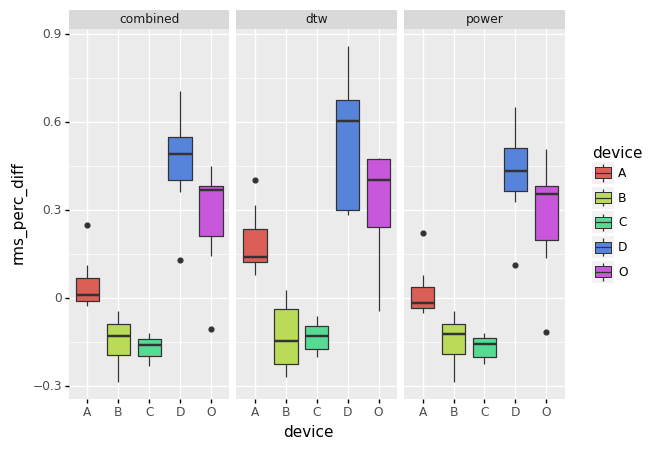

<ggplot: (-9223363293005876627)>

In [18]:
p = ggplot(aes(x='device', y='rms_perc_diff', fill='device'), m1_parsed_mech['scores'])
p + geom_boxplot() + facet_grid('. ~ cost_metric')

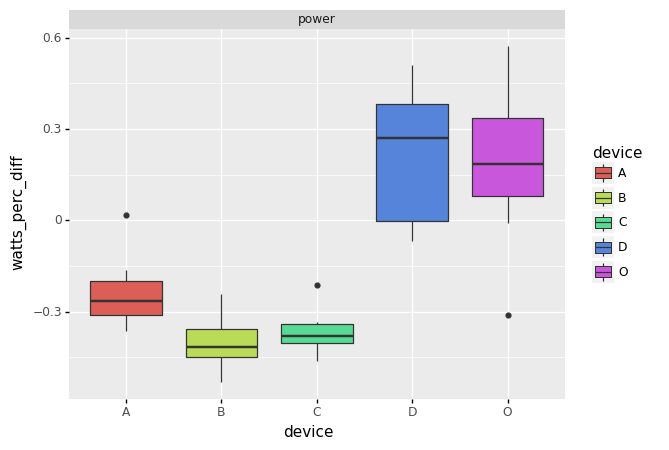

<ggplot: (8743848831864)>

In [19]:
import matplotlib

matplotlib.rcParams['text.usetex'] = False
p = ggplot(aes(x='device', y='watts_perc_diff', fill='device'), m2_parsed_mech['scores'].query('cost_metric == "power"'))
p + geom_boxplot() + facet_grid('. ~ cost_metric')

In [20]:
df_m2_plot = m2_parsed_mech['scores'].melt(id_vars=['device', 'input_id', 'cost_metric']).query('variable.isin(["y_diff_dtw_norm", "emf_dtw_norm", "rms_perc_diff"])')
df_m2_plot = df_m2_plot.query('cost_metric == "power" and device != "O"')
df_m2_plot['variable'] = pd.Categorical(df_m2_plot['variable'], categories=['y_diff_dtw_norm', 'emf_dtw_norm', 'rms_perc_diff'], ordered=True)
df_m2_plot.head()

,device,input_id,cost_metric,variable,value
140,A,0,power,y_diff_dtw_norm,0.003712
141,A,1,power,y_diff_dtw_norm,0.004238
142,A,2,power,y_diff_dtw_norm,0.004026
143,A,3,power,y_diff_dtw_norm,0.003811
144,A,6,power,y_diff_dtw_norm,0.003736


In [31]:
# Producing plots for the paper
import matplotlib
import logging
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.serif'] = 'Computer Modern'
matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']
logging.getLogger("matplotlib").setLevel(logging.WARNING)

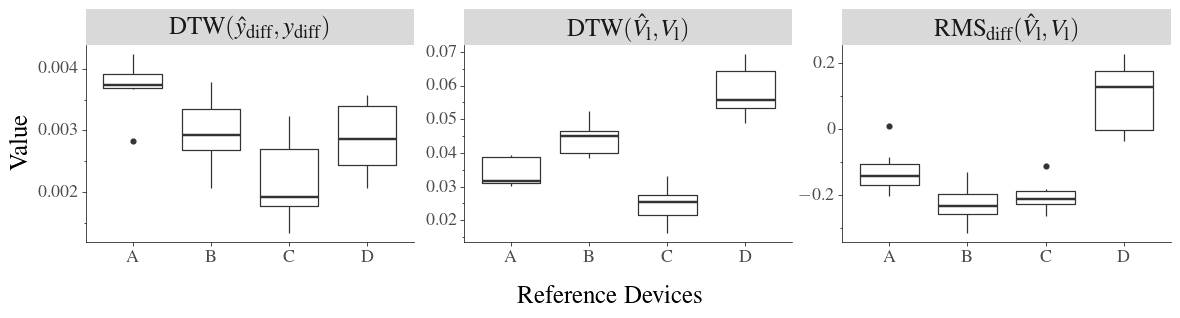

<ggplot: (-9223363293018973205)>

In [32]:
# Produce plot for paper
import phd_theme

facet_lookup = {
    'y_diff_dtw_norm': r'$\text{DTW}(\hat{y}_{\text{diff}},y_{\text{diff}})$',
    'emf_dtw_norm': r'$\text{DTW}(\hat{V}_{\text{l}},V_{\text{l}})$',
    'rms_perc_diff': r'$\text{RMS}_{\text{diff}}(\hat{V}_{\text{l}},V_{\text{l}})$'
}

p = ggplot(aes(x='device', y='value'), df_m2_plot)
p = (
    p
    + geom_boxplot()
    + facet_wrap('variable', scales="free", labeller=lambda x: facet_lookup[x])
    + xlab('Reference Devices')
    + ylab('Value')
    + phd_theme.phd_theme_bigger()
    + theme(aspect_ratio=0.6,
            figure_size=(14, 3),
            panel_spacing_x = 0.5,
            strip_text=element_text(margin={'t': 6, 'b': 6}),
            axis_title_x=element_text(margin={'t': 15}))
)


#p.save('/home/michael/Nextcloud/nextcloud/PhD/LaTeX/Journal2/img/reference_device_boxplot.pdf')
p

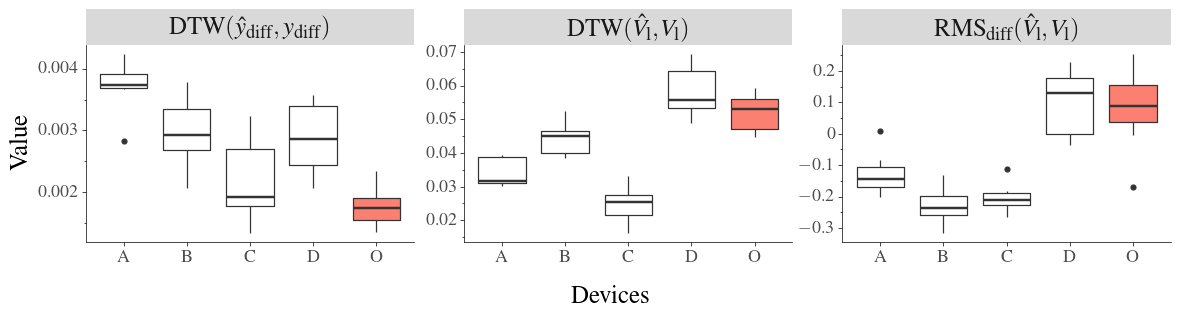

<ggplot: (-9223363250318450621)>

In [20]:
df_m2_o_plot = m2_parsed_mech['scores'].melt(id_vars=['device', 'input_id', 'cost_metric']).query('variable.isin(["y_diff_dtw_norm", "emf_dtw_norm", "rms_perc_diff"])')
df_m2_o_plot = df_m2_o_plot.query('cost_metric == "power"')
df_m2_o_plot['variable'] = pd.Categorical(df_m2_o_plot['variable'], categories=['y_diff_dtw_norm', 'emf_dtw_norm', 'rms_perc_diff'], ordered=True)
df_m2_o_plot['variable.tex'] = df_m2_o_plot['variable'].apply(lambda x: facet_lookup[x])
df_m2_o_plot['fill'] = df_m2_o_plot['device'].apply(lambda x: '1' if x == 'O' else '0')

p = ggplot(aes(x='device', y='value', fill='fill'), df_m2_o_plot)
p = (
    p
    + geom_boxplot()
    + facet_wrap('variable', scales="free", labeller=lambda x: facet_lookup[x])
    + xlab('Devices')
    + ylab('Value')
    + phd_theme.phd_theme_bigger()
    + theme(aspect_ratio=0.6,
            figure_size=(14, 3),
            panel_spacing_x = 0.5,
            strip_text=element_text(margin={'t': 6, 'b': 6}),
            axis_title_x=element_text(margin={'t': 15}))
    + scale_fill_manual({'1': '#fb8072', '0': 'white'}, guide=False)
)

#p.save('/home/michael/Nextcloud/PhD/LaTeX/Journal2/img/all_devices_boxplot.pdf')
p

## Emperical comparison

In [23]:
def get_melted_result_curves(df_curves: pd.DataFrame):
    """Melt parsed results to for making instantaneous line plots."""
    
    # Check if we're dealing with mechanical or electrical result
    if 'y_target' in df_curves.columns:
        which_component = 'mech'
    elif 'emf_target' in df_curves.columns:
        which_component = 'elec'
        
    if which_component == 'mech':
        id_vars = ['input_id', 'device', 'y_time', 'cost_metric']
        df_curves = df_curves.melt(id_vars=id_vars)
        var_cat = pd.Categorical(df_curves['variable'].values, categories=['y_target', 'y_predict'], ordered=True)
    elif which_component == 'elec':
        id_vars= ['input_id', 'device', 'emf_time', 'cost_metric']
        df_curves = df_curves.melt(id_vars=id_vars)
        var_cat = pd.Categorical(df_curves['variable'].values, categories=['emf_target', 'emf_predict'], ordered=True)
    
    df_curves['variable'] = var_cat
    return df_curves

def reset_input_ids(df_melt_curves: pd.DataFrame):
    df_melt_curves = copy.copy(df_melt_curves)
    for device in df_melt_curves['device'].unique():
        df_dev = df_melt_curves.query(f'device == "{device}"')
        input_ids = sorted(df_melt_curves.query(f'device == "{device}"')['input_id'].unique())
        numbered_input_ids = zip(input_ids, range(len(input_ids)))
        for id_, new_id in numbered_input_ids:
            indices = df_melt_curves.query(f'device == "{device}" and input_id == {id_}').index
            df_melt_curves.loc[indices, 'input_id'] = new_id
    return df_melt_curves
    
    

In [24]:
m1_mech_curves = get_melted_result_curves(m1_parsed_mech['curves'].query('y_target > 0'))
m2_mech_curves = get_melted_result_curves(m2_parsed_mech['curves'].query('y_target > 0'))

m1_mech_melted = reset_input_ids(m1_mech_curves.query('cost_metric == "power"'))
m2_mech_melted = reset_input_ids(m2_mech_curves.query('cost_metric == "power"'))

In [25]:
m2_mech_melted.head()

,input_id,device,y_time,cost_metric,variable,value
124443,0,A,0.0000,power,y_target,0.045654
124444,0,A,0.0008,power,y_target,0.045631
124445,0,A,0.0016,power,y_target,0.045609
124446,0,A,0.0024,power,y_target,0.045587
124447,0,A,0.0032,power,y_target,0.045567


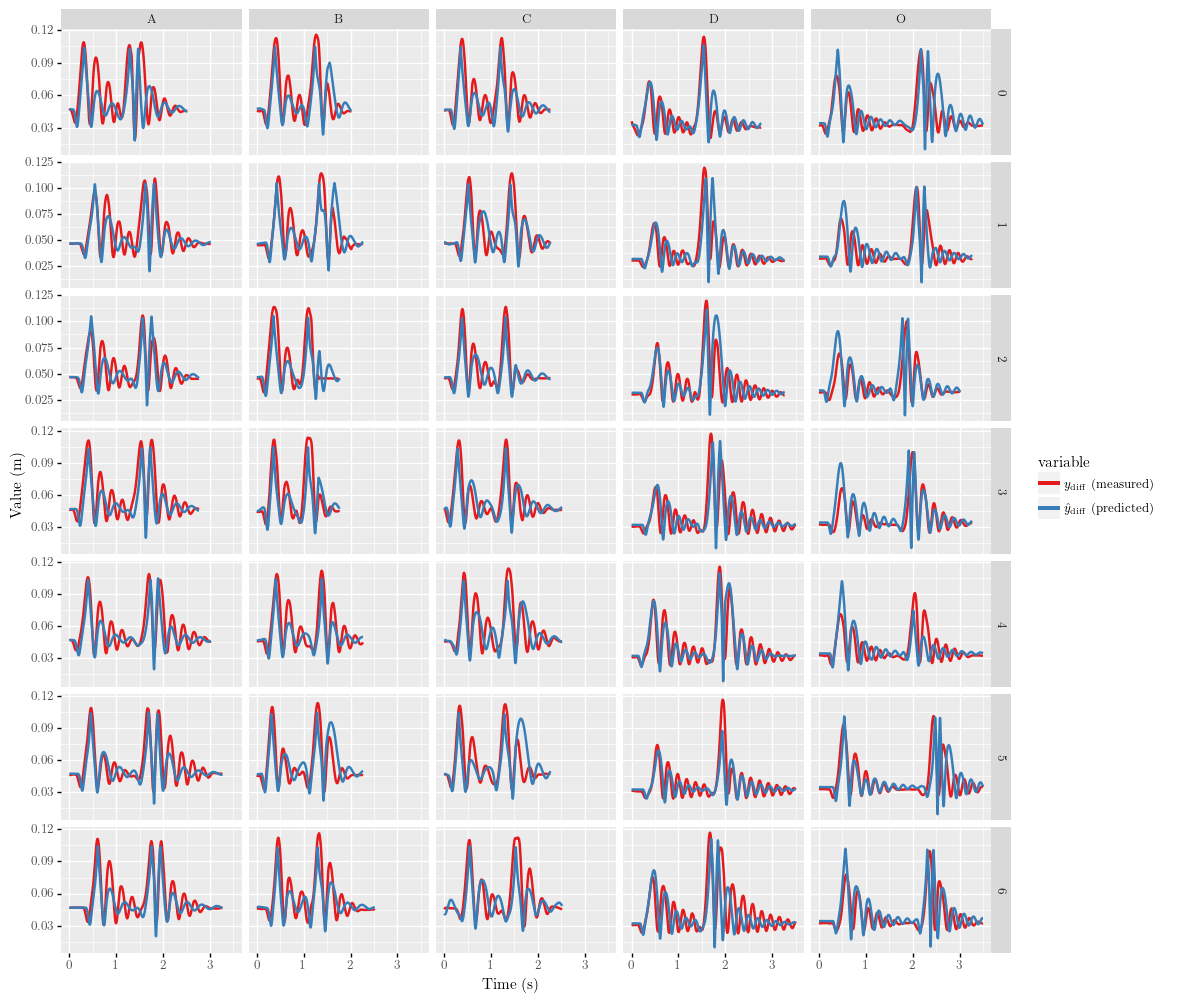

<ggplot: (8771637941889)>

In [241]:
p = ggplot(aes(x='y_time', y='value', color='variable'), m1_mech_melted)
p \
+ geom_line(size=1) \
+ facet_grid('input_id ~ device', scales='free_y') \
+ xlim(0, 3.5) \
+ xlab('Time (s)') \
+ ylab('Value (m)') \
+ scale_color_brewer('qual', 6, labels=labeller) \
+ theme(figure_size=(12, 12)) \

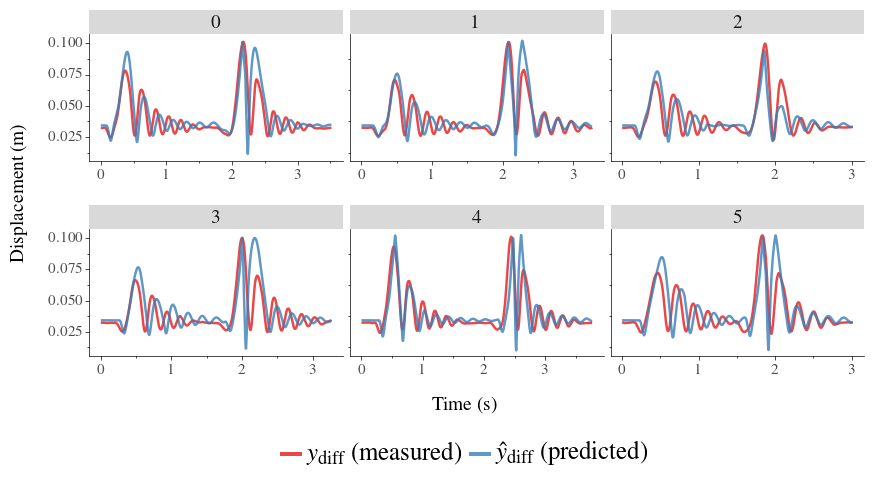

<ggplot: (8780107679485)>

In [151]:
matplotlib.rcParams['text.usetex'] = True  # Flip this switch later

def labeller(x):
    labels = {
        'y_target': r'$y_{\mathrm{diff}}$ (measured)',
        'y_predict': r'$\hat{y}_{\mathrm{diff}}$ (predicted)'
    }
    return [labels[x] for x in x]


p = ggplot(aes(x='y_time', y='value', color='variable'), m2_mech_melted.query('device == "O" and input_id < 6'))
p = (
    p
    + geom_line(size=1, alpha=0.8)
    + facet_wrap('input_id', scales='free_x', ncol=3)
    + xlab('Time (s)')
    + ylab('Displacement (m)')
    + scale_color_brewer('qual', 6, labels=labeller, name=' ')
    + phd_theme.phd_theme()
    + theme(figure_size=(10, 10),
            aspect_ratio=0.5,
            legend_text=element_text(size=18),
            legend_position='bottom',
            legend_direction='horizontal',
            legend_box_spacing=0.5,
            panel_spacing_y=0.,
            axis_title_y=element_text(margin={'r': 15}),
            axis_title_x=element_text(margin={'t': 15}),
            strip_text=element_text(margin={'t':20, 'b': 15}))
)

p.save('/home/michael/Nextcloud/nextcloud/PhD/LaTeX/Journal2/img/optim_mech_lines.pdf')
p

Can you subjectively tell which looks better? I think Method 2 _looks_ better.

### Elec

In [26]:
m1_elec_curves = get_melted_result_curves(m1_parsed_elec['curves'])
m2_elec_curves = get_melted_result_curves(m2_parsed_elec['curves'])

m1_elec_melted = reset_input_ids(m2_elec_curves.query('cost_metric == "power"'))
m2_elec_melted = reset_input_ids(m2_elec_curves.query('cost_metric == "power"'))

In [27]:
m2_elec_melted.head()

,input_id,device,emf_time,cost_metric,variable,value
355328,0,A,0.000000,power,emf_target,-0.095331
355329,0,A,0.000710,power,emf_target,-0.095316
355330,0,A,0.001421,power,emf_target,-0.095196
355331,0,A,0.002131,power,emf_target,-0.094635
355332,0,A,0.002841,power,emf_target,-0.092836


In [28]:
def clip_samples_manual(df_melted_curves, clip_at):
    df_melted_curves = copy.deepcopy(df_melted_curves)
    for input_, (start, stop) in clip_at.items():
        idxs = df_melted_curves.query(f'input_id == {input_} and {start} > emf_time').index.tolist()
        idxs2 = df_melted_curves.query(f'input_id == {input_} and {stop} < emf_time').index.tolist()  # break things up to avoid bool logic complexity
        df_melted_curves = df_melted_curves.drop(idxs + idxs2)
    return df_melted_curves

In [29]:
m2_elec_melted_O = m2_elec_melted.query('device == "O"')

m2_elec_melted_O = clip_samples_manual(m2_elec_melted_O, {0: (3.25, 6),
                                                          1: (3, 5.75),
                                                          2: (3, 5.25),
                                                          3: (2.5, 5),
                                                          4: (2.75, 5.75),
                                                          5: (3, 5.5),
                                                          6: (3.25, 6.25)})

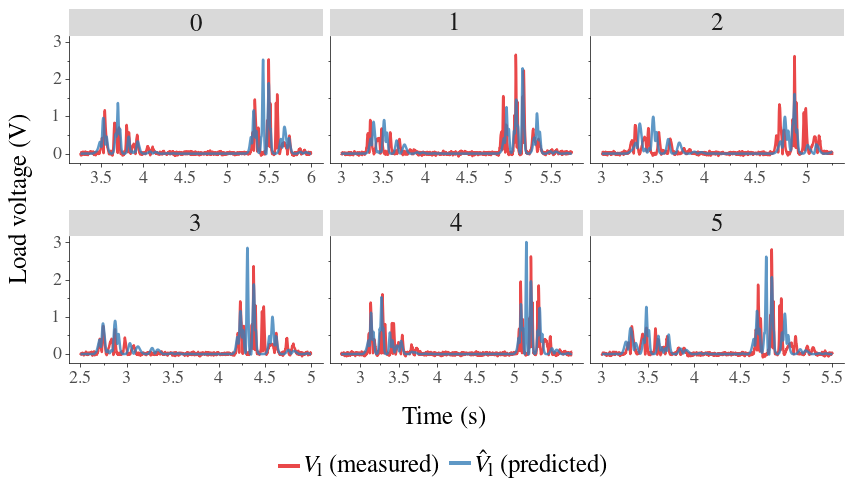

<ggplot: (-9223363292901454641)>

In [33]:
matplotlib.rcParams['text.usetex'] = True

def labeller(x):
    labels = {
        'emf_target': r'$V_{\mathrm{l}}$ (measured)',
        'emf_predict': r'$\hat{V}_{\mathrm{l}}$ (predicted)'
    }
    return [labels[x] for x in x]

p = ggplot(aes(x='emf_time', y='value', color='variable'), m2_elec_melted_O.query('input_id < 6'))
p = (
    p
    + geom_line(size=1, alpha=0.8)
    + facet_wrap('input_id', scales='free_x', ncol=3)
    + scale_color_brewer('qual', 6, labels=labeller, name=' ')
    + scale_x_continuous(breaks=np.arange(0, 7, 0.5))
    + xlab('Time (s)')
    + ylab('Load voltage (V)')
    + phd_theme.phd_theme_bigger()
    + theme(figure_size=(10, 10),
            aspect_ratio=0.5,
            legend_text=element_text(size=18),
            legend_position='bottom',
            legend_direction='horizontal',
            legend_box_spacing=0.5,
            panel_spacing_y=0.0,
            axis_title_y=element_text(margin={'r': 15}),
            axis_title_x=element_text(margin={'t': 15}),
            strip_text=element_text(margin={'t':20, 'b': 15}))
)
p.save('/home/michael/Nextcloud/nextcloud/PhD/LaTeX/Journal2/img/optim_elec_lines.pdf')
p

In [34]:
m2_elec_curves

,input_id,device,emf_time,cost_metric,variable,value
0,1,A,0.000000,dtw,emf_target,-0.095557
1,1,A,0.000781,dtw,emf_target,-0.095549
2,1,A,0.001563,dtw,emf_target,-0.095473
3,1,A,0.002344,dtw,emf_target,-0.095092
4,1,A,0.003125,dtw,emf_target,-0.093753
...,...,...,...,...,...,...
2152443,9,O,8.316875,combined,emf_predict,0.000000
2152444,9,O,8.317500,combined,emf_predict,0.000000
2152445,9,O,8.318125,combined,emf_predict,0.000000
2152446,9,O,8.318750,combined,emf_predict,0.000000


In [35]:
# Power plots
from unified_model.metrics import root_mean_square

m2_elec_curves_pow=  m2_elec_curves.query('cost_metric == "power"')

# Calculate the RMS
def rms(x):
    x_rms = np.sqrt((np.sum(x * x) / len(x)))
    return x_rms

target_power_data = {dev: {} for dev in m2_elec_curves_pow['device'].unique()}
predict_power_data = {dev: {} for dev in m2_elec_curves_pow['device'].unique()}

load = 30
for device in m2_elec_curves_pow['device'].unique():
    df_dev = m2_elec_curves_pow.query(f'device == "{device}"')
    for i, input_ in enumerate(df_dev['input_id'].unique()):
        target_v_l = df_dev.query(f'input_id == {input_} and variable == "emf_target"')['value'].values
        predict_v_l = df_dev.query(f'input_id == {input_} and variable == "emf_predict"')['value'].values
        
        target_rms = rms(target_v_l)
        predict_rms = rms(predict_v_l)
        
        target_power = target_rms*target_rms / load
        predict_power = predict_rms*predict_rms / load
        
        target_power_data[device][i] = target_power
        predict_power_data[device][i] = predict_power

df_target = pd.DataFrame(target_power_data)
df_predict = pd.DataFrame(predict_power_data)
df_target['which'] = 'target'
df_predict['which'] = 'predict'

In [36]:
df = pd.concat([df_target, df_predict])
df.head()

,A,B,C,D,O,which
0,0.000070,0.000222,0.000118,0.000361,0.001074,target
1,0.000154,0.000251,0.000113,0.000495,0.001111,target
2,0.000159,0.000205,0.000075,0.000562,0.000883,target
3,0.000096,0.000161,0.000108,0.000589,0.000836,target
4,0.000119,0.000244,0.000114,0.000717,0.001393,target


In [37]:
df_melt = df.melt(id_vars=['which'], value_vars=['A', 'B', 'C', 'D', 'O'])

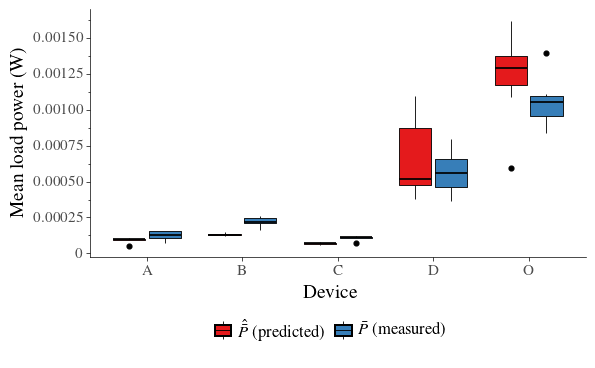

<ggplot: (8743916140755)>

In [44]:
def labeller(x):
    labels = {
        'target': r'$\bar{P}$ (measured)',
        'predict': r'$\hat{\bar{P}}$ (predicted)'
    }
    return [labels[x] for x in x]


p = ggplot(aes(x='variable', y='value', fill='which'), df_melt)
p = (
    p
    + geom_boxplot(color='black', size=0.35)
    + xlab('Device')
    + ylab(r'Mean load power (W)')
    + scale_fill_brewer('qual', 6, labels=labeller, name=' ')
    + scale_y_continuous(breaks=np.arange(0, 0.00200, 0.00025))
    + phd_theme.phd_theme()
    + theme(legend_text=element_text(size=12),
            aspect_ratio=0.5,
            legend_position='bottom',
            legend_direction='horizontal',
            legend_box_spacing=0.25)
)

p.save('/home/michael/Nextcloud/nextcloud/PhD/LaTeX/Journal2/img/all_devices_power_comparison.pdf')
p

In [151]:
df.head().query('which=="target"').mean()

A    0.000120
B    0.000216
C    0.000106
D    0.000545
O    0.001059
dtype: float64

In [154]:
print(0.001059/0.000120)  # A
print(0.001059/0.000216)  # B
print(0.001059/0.000106)  # C
print(0.001059/0.000545)  # D

8.825
4.902777777777779
9.99056603773585
1.9431192660550458
